In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [ ]:
!kaggle datasets download -d mervecayli/detection-of-down-syndrome-in-children

 16% 5.00M/30.5M [00:00<00:00, 33.5MB/s]
100% 30.5M/30.5M [00:00<00:00, 125MB/s] 


In [ ]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from zipfile import ZipFile
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import random
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 15
BATCH_SIZE = 8

In [ ]:
file_name = "/content/detection-of-down-syndrome-in-children.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
from tqdm.notebook import tqdm_notebook as tqdm

In [ ]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = os.listdir(path)
    for i in tqdm(images, desc = 'images' ):
        full_path.append(os.path.join(path, i))

    return full_path


data_healthy = create_images_list('/content/healty/healty')
data_down = create_images_list('/content/downSyndorme/downSyndrome')


# look-up table
disease_classes = {0:'healthy', 1 : 'down' }
data_df = pd.concat([  pd.DataFrame({"img" : np.array(data_healthy) , "label": 0 }),
                        pd.DataFrame({"img" : np.array(data_down) , "label": 1 }) ], ignore_index = True)


data_df = shuffle(data_df).reset_index(drop = True)

images:   0%|          | 0/1499 [00:00<?, ?it/s]

images:   0%|          | 0/1500 [00:00<?, ?it/s]

In [ ]:
# Creating random 4 sample from a dataframe


def create_img_label_sample(data, index):

    img = cv2.imread(data['img'][index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = disease_classes[data_df['label'][index]]

    return img, label


def create_random_samples(data):

    idx1,idx2,idx3,idx4 =np.random.permutation(data.shape[0])[:4]

    fig, axs = plt.subplots(1,4, figsize = (12,5), dpi = 300)

    img1, name1 = create_img_label_sample(data, idx1)
    img2, name2 = create_img_label_sample(data, idx2)
    img3, name3 = create_img_label_sample(data, idx3)
    img4, name4 = create_img_label_sample(data, idx4)
    axs[0].imshow(img1)
    axs[0].set_title(name1)
    axs[0].axis('off')

    axs[1].imshow(img2)
    axs[1].set_title(name2)
    axs[1].axis('off')

    axs[2].imshow(img3)
    axs[2].set_title(name3)
    axs[2].axis('off')

    axs[3].imshow(img4)
    axs[3].set_title(name4)
    axs[3].axis('off')

    plt.show()

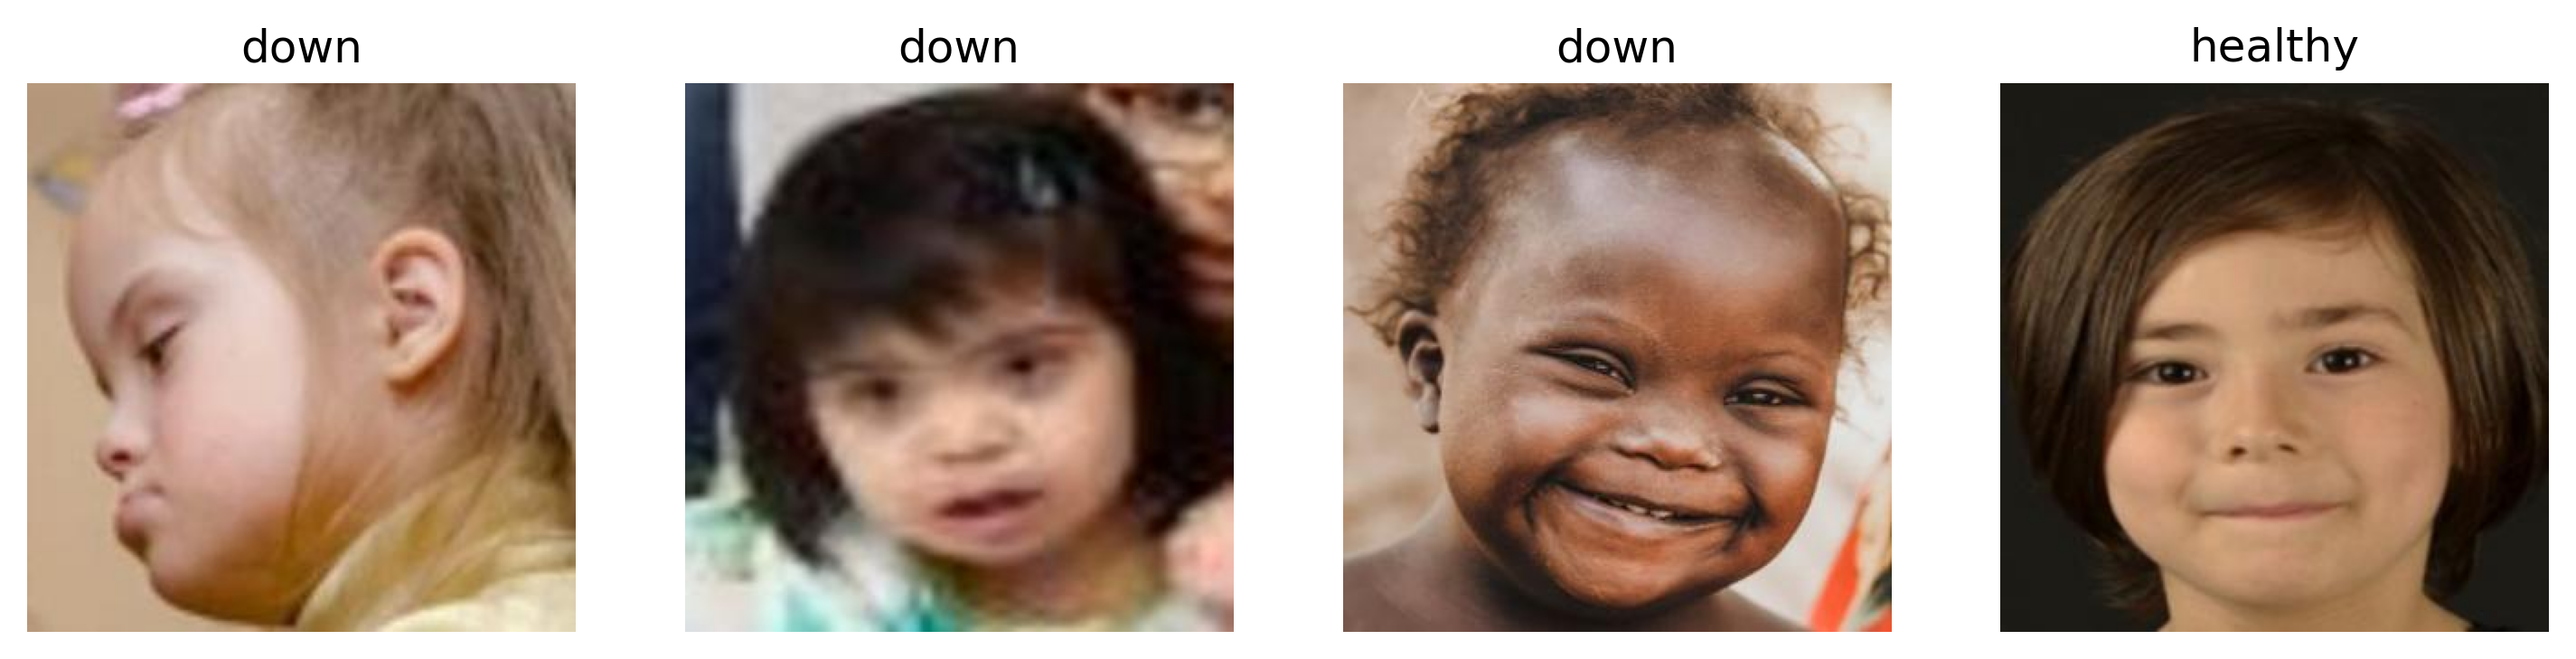

In [ ]:
create_random_samples(data_df)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_df['img'], data_df['label'], test_size = 0.15,  random_state = SEED)

print("train images: ", X_train.shape[0])
print("test images: ", X_test.shape[0])

train images:  2549
test images:  450


In [ ]:
def img_preprocessing(image, label):

    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (224,224))
    img = img/255.0

    return img, label

In [ ]:
train_loader = tf.data.Dataset.from_tensor_slices(( X_train, y_train) )
train_dataset = (train_loader.map(img_preprocessing).batch(BATCH_SIZE).shuffle(X_train.shape[0]).prefetch(BATCH_SIZE))

test_loader = tf.data.Dataset.from_tensor_slices(( X_test, y_test) )
test_dataset = (test_loader.map(img_preprocessing).batch(BATCH_SIZE).prefetch(BATCH_SIZE))

In [ ]:
def create_Base_model_from_VGG19():
    model_vgg19 = VGG19(
        weights = "imagenet",# control point from which model is started
        include_top=False, # to include/exclude the first 3 layers
        input_shape = (224,224, 3)) # image size
    # don't train existing weights
    for layer in model_vgg19.layers:
      layer.trainable = False
    return model_vgg19
create_Base_model_from_VGG19().summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
from tensorflow.keras.models import Model
num_classes = 1
def add_custom_layers_vgg19():
    #Adding custom Layers
    model_vgg19 = create_Base_model_from_VGG19()
    x = model_vgg19.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    predictions = tf.keras.layers.Dense(num_classes, activation="sigmoid")(x)


    # creating the final model
    model = tf.keras.models.Model(
        inputs = model_vgg19.input,
        outputs = predictions)


    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','AUC','Precision','Recall'])
    return model

add_custom_layers_vgg19().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
my_callbacks = [EarlyStopping(monitor = 'loss', patience = 8, min_delta = 0.0001)]



In [ ]:
model_from_vgg19 = add_custom_layers_vgg19()
history = model_from_vgg19.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset,
                    verbose = 1,
                    callbacks = my_callbacks,
                    initial_epoch=0)

Epoch 1/10
319/319 [==============================] - 2310s 7s/step - loss: 0.6870 - accuracy: 0.7607 - auc: 0.8295 - precision: 0.7627 - recall: 0.7603 - val_loss: 1.0196 - val_accuracy: 0.6622 - val_auc: 0.9188 - val_precision: 0.5913 - val_recall: 0.9909
Epoch 2/10
319/319 [==============================] - 2305s 7s/step - loss: 0.3012 - accuracy: 0.8729 - auc: 0.9460 - precision: 0.8724 - recall: 0.8751 - val_loss: 0.3488 - val_accuracy: 0.8489 - val_auc: 0.9301 - val_precision: 0.8512 - val_recall: 0.8356
Epoch 3/10
319/319 [==============================] - 2322s 7s/step - loss: 0.1995 - accuracy: 0.9121 - auc: 0.9760 - precision: 0.9184 - recall: 0.9055 - val_loss: 0.4149 - val_accuracy: 0.8467 - val_auc: 0.9357 - val_precision: 0.7885 - val_recall: 0.9361
Epoch 4/10
319/319 [==============================] - 2316s 7s/step - loss: 0.1222 - accuracy: 0.9541 - auc: 0.9915 - precision: 0.9533 - recall: 0.9555 - val_loss: 0.8306 - val_accuracy: 0.7511 - val_auc: 0.9172 - val_precisi

In [ ]:
# prompt: write a code for saving the above cnn model in down.h5 file

model_from_vgg19.save('down.h5')


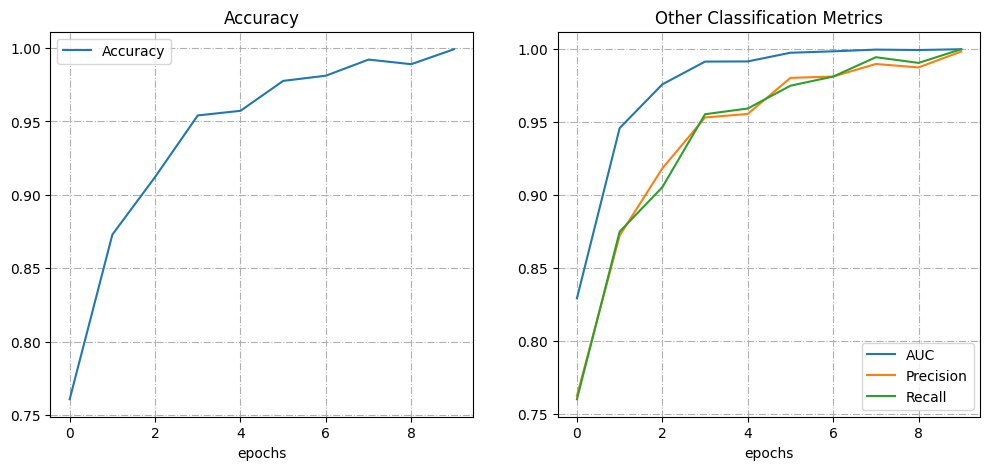

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (12,5), dpi = 100)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Accuracy")
axs[0].plot(history.history['accuracy'])
axs[0].set_xlabel("epochs")
axs[0].legend(["Accuracy"])


axs[1].grid(linestyle="dashdot")
axs[1].set_title("Other Classification Metrics")
axs[1].plot(history.history['auc'])
axs[1].plot(history.history['precision'])
axs[1].plot(history.history['recall'])
axs[1].set_xlabel("epochs")
axs[1].legend(["AUC", "Precision", "Recall"])

In [ ]:
# Test set evaluation

test_eval = model_from_vgg19.evaluate(test_dataset)

print('test accuracy : {0:.3f} %'.format(test_eval[1]*100))
print('test auc : {0:.3f}'.format(test_eval[2]))
print('test precision : {0:.3f}'.format(test_eval[3]))
print('test recall : {0:.3f}'.format(test_eval[4]))

In [ ]:

test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model_from_vgg19.predict(test_take1)
pred_ = np.round(pred)

y_test_take = []
for x in range(len(test_take1_)):
    y_test_take.extend(test_take1_[x][1].numpy())

57/57 [==============================] - 210s 4s/step


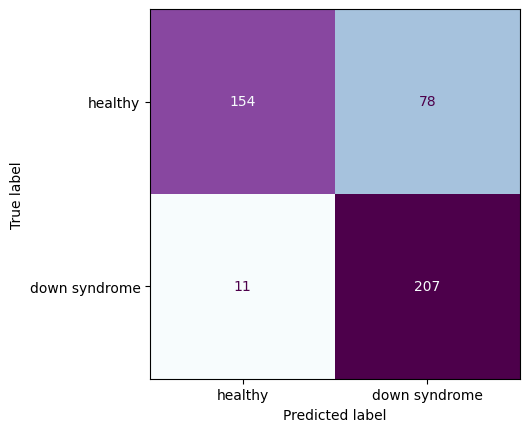

In [ ]:
# Plotting the confusion matrix

cm = confusion_matrix(y_test_take, pred_)
cmd = ConfusionMatrixDisplay(cm, display_labels= ['healthy','down syndrome'])
cmd.plot(cmap = 'BuPu',colorbar = False )

In [ ]:
report = classification_report(np.array(y_test_take), pred_)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.66      0.78       232
           1       0.73      0.95      0.82       218

    accuracy                           0.80       450
   macro avg       0.83      0.81      0.80       450
weighted avg       0.83      0.80      0.80       450

